# Mixture Model

In this excersise we want to implement a mixture model.
We will start to implement the Gaussian mixture model and test it on artifical data.
Furthermore, we will take a look how the mixture model converges to the final solution.

Once the Gaussian mixture model works, we want to apply it to an unsupervised task.
We take an image as input and model the color as feature with 3 components.
When a Gaussian mixture model is trained on the image, we can quantize the image.

As final task, we want to implement a Bernoulli mixture model and apply it to the suppervised MNIST task:
 - Train one Bernoulli mixture model for each digit on the training data
 - To evaluate the model, you assign the digit to the test sample from the the mixture model that most likly produced this sample.
 - You should be able to get a accuracy over 90 %


In [1]:
%matplotlib inline

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## GMM

 - Implement the missing code in the GaussianMixtureModel.
 - Test it on the artificial generated data in the cells below.

In [2]:
class GaussianMixtureModel:
    """Gaussian Mixture Model (GMM) implementation using Expectation-Maximization (EM) algorithm.
    
    Attributes:
        means (ndarray): Means of the Gaussian components. Shape: (K, D)
        covariances (ndarray): Covariance matrices of the Gaussian components. Shape: (K, D, D)
        weights (ndarray): Mixing coefficients for each component. Shape: (K,)
    """
    def __init__(self):
        """Initialize a GMM with uninitialized parameters."""
        self.means = None  # Shape (K, D)
        self.covariances = None  # Shape (K, D, D)
        self.weights = None  # Shape (K,)
    
    @classmethod
    def fit(cls, x, num_classes,* , initialization=None, iterations=100, minimum_increase=1e-2, verbose=False):
        """Fit a GMM to the input data using the EM algorithm.
        
        Args:
            x (ndarray): Input data of shape (N, D) where N is the number of samples
                        and D is the number of features.
            num_classes (int): Number of mixture components (K).
            initialization (ndarray, optional): Initial component affiliations.
                                              Shape (K, N).
            iterations (int, optional): Maximum number of EM iterations.
            minimum_increase (float, optional): Minimum increase in log-likelihood
                                              for convergence.
            verbose (bool, optional): Whether to print convergence messages.
            
        Returns:
            tuple: (model, affiliations, log_likelihood)
                - model: Fitted GMM instance
                - affiliations: Final component responsibilities. Shape (K, N)
                - log_likelihood: Final log-likelihood of the model
        """
        N, D = x.shape
        model = cls()
        
        # Initialization
        if initialization is None:
            affiliations = np.random.uniform(size=(num_classes, N))  # REPLACE affiliations = ???
            affiliations /= affiliations.sum(axis=0)  # REPLACE 
        else:
            affiliations = np.copy(initialization)
        
        # EM iterations
        last_log_likelihood = -np.inf
        iteration = 0
        while True:
            model._m_step(x, affiliations)
            affiliations, log_likelihood = model._e_step(x)
            log_likelihood = np.sum(log_likelihood)
            
            if log_likelihood < last_log_likelihood:
                print('Likelihood should always increase: {} < {}'.format(log_likelihood, last_log_likelihood))
            
            if np.abs(log_likelihood - last_log_likelihood) < minimum_increase:
                if verbose:
                    print('Minimum likelihood change not reached.')
                break
            
            if iteration >= iterations:
                if verbose:
                    print('Maximum number of iterations exhausted.')
                break
            
            iteration += 1
            last_log_likelihood = log_likelihood
            
        if verbose:
            print('Stopping after {} iterations.'.format(iteration))
        
        return model, affiliations, log_likelihood
    
    def _m_step(self, x, affiliations):
        """Maximization step of the EM algorithm.
        
        Updates the model parameters (means, covariances, weights) to maximize
        the expected log-likelihood.
        
        Args:
            x (ndarray): Input data. Shape (N, D)
            affiliations (ndarray): Component responsibilities. Shape (K, N)
        """
        N, D = x.shape
        denominator = np.einsum('kn->k', affiliations)  # REPLACE denominator = ???
        self.weights = denominator / N  # REPLACE self.weights = ???
        
        self.means = np.einsum('kn,nd->kd', affiliations, x)  # REPLACE self.means = ???
        self.means /= denominator[:, None]  # REPLACE self.means /= ???
        
        difference = x[None, :, :] - self.means[:, None, :]  # Shape (K, N, D)  # REPLACE difference = ???  # Shape (K, N, D)
        self.covariances = np.einsum('kn,knd,knD->kdD', affiliations, difference, difference)  # REPLACE self.covariances = ???
        self.covariances /= denominator[:, None, None]  # REPLACE self.covariances /= ???
    
    def _e_step(self, x):
        """Expectation step of the EM algorithm.
        
        Computes the responsibilities of each component for each data point.
        
        Args:
            x (ndarray): Input data. Shape (N, D)
            
        Returns:
            tuple: (affiliations, log_likelihood)
                - affiliations: Updated component responsibilities. Shape (K, N)
                - log_likelihood: Log-likelihood of the current model. Shape (N,)
        """
        N, D = x.shape
        K = self.weights.shape[0]
        
        # Normalization constant of the Gaussian distribution
        log_conditional_pdf = np.zeros((K, N))
        log_conditional_pdf += -1/2 * D * np.log(2 * np.pi) - 1/2 * np.log(np.linalg.det(self.covariances))[:, None]  # log_conditional_pdf += ???
        
        # Exponent of the Gaussian distribution
        difference = x[None, :, :] - self.means[:, None, :]  # Shape (K, N, D)  # REPLACE difference = ???  # Shape (K, N, D)
        log_conditional_pdf += -1/2 * np.einsum('knd,kdn->kn', difference, np.linalg.solve(self.covariances, difference.transpose(0, 2, 1)))  # log_conditional_pdf += ???
        
        log_joint_pdf = log_conditional_pdf + np.log(self.weights)[:, None]  # REPLACE log_joint_pdf = ???
        affiliations = np.exp(log_joint_pdf)  # REPLACE affiliations = ???
        affiliations /= np.maximum(np.einsum('kn->n', affiliations)[None, :], np.finfo(affiliations.dtype).tiny)  # REPLACE affiliations /= np.maximum(???, np.finfo(affiliations.dtype).tiny)
        
        Q = np.einsum('kn,kn->', affiliations, log_joint_pdf)  # REPLACE
        log_likelihood = scipy.special.logsumexp(log_joint_pdf, axis=-2)  # REPLACE log_likelihood = ???  # see scipy.special.logsumexp
        
        return affiliations, log_likelihood


# Generate artificial data

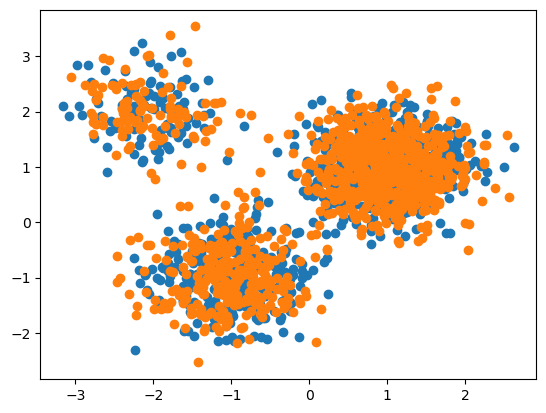

In [4]:
N = 1000
p = np.array([0.3, 0.6, 0.1])
K = p.shape[0]
labels = np.random.choice(range(K), size=(N,), p=p)
means = np.array([[-1, -1], [1, 1], [-2, 2]])
D = means.shape[-1]
x = np.sqrt(1 / 4) * np.random.normal(size=(N, D))

for k in range(K):
    x[labels == k, :] += means[k, :]

plt.scatter(x[:, 0], x[:, 1])
plt.show()

# Artificial test with just a few iterations

In [5]:
def compute_complete_grid(xlim, ylim, steps):
    x, y = np.meshgrid(
        np.linspace(*xlim, steps),
        np.linspace(*ylim, steps)
    )
    return x, y, np.stack([x, y]).T

def plot_multivariate_normal(mean, covariance, ax=None):
    assert mean.shape == (2,), mean
    assert covariance.shape == (2, 2), covariance
    
    steps = 100
    
    xlim = [mean[0] - 2 * np.sqrt(covariance[0, 0]), mean[0] + 2 * np.sqrt(covariance[0, 0])]
    ylim = [mean[1] - 2 * np.sqrt(covariance[1, 1]), mean[1] + 2 * np.sqrt(covariance[1, 1])]
    
    x, y, features_grid = compute_complete_grid(xlim, ylim, steps)
    z = scipy.stats.multivariate_normal.pdf(features_grid, mean, covariance)
    level1std = scipy.stats.multivariate_normal.pdf(np.zeros([D]), np.zeros([D]), model.covariances[0]) * np.exp(-0.5 * 1 ** 2)
    if ax is None:
        ax = plt
    ax.contour(x, y, z, [level1std])
    ax.scatter(mean[0], mean[1], color='red')

Maximum number of iterations exhausted.
Stopping after 1 iterations.


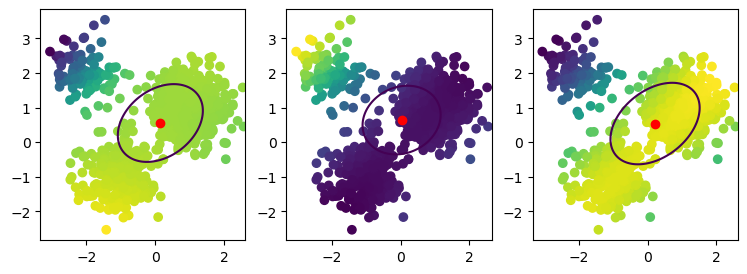

-3115.0142872860874
Maximum number of iterations exhausted.
Stopping after 1 iterations.


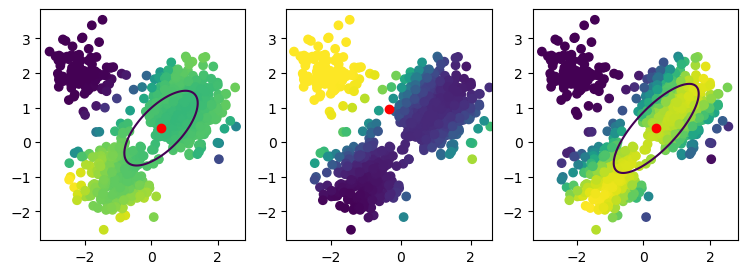

-2880.971029454859
Maximum number of iterations exhausted.
Stopping after 1 iterations.


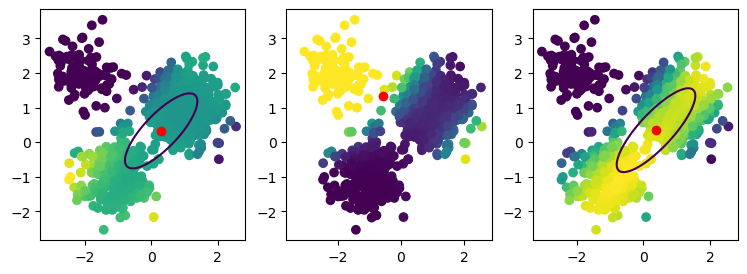

-2805.07204141322
Maximum number of iterations exhausted.
Stopping after 1 iterations.


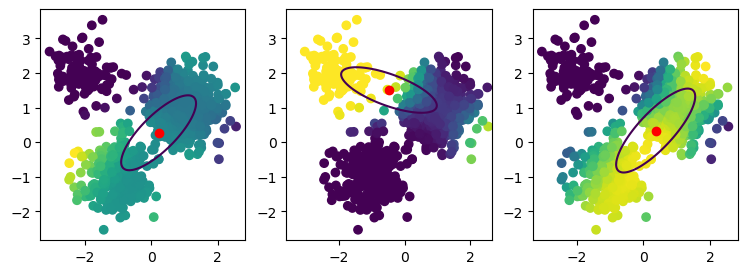

-2761.5548638982455
Maximum number of iterations exhausted.
Stopping after 1 iterations.


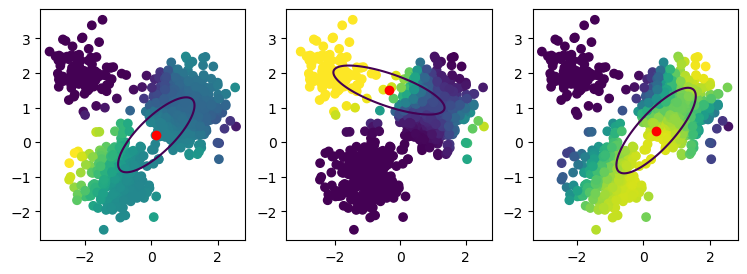

-2755.022880179288
Maximum number of iterations exhausted.
Stopping after 1 iterations.


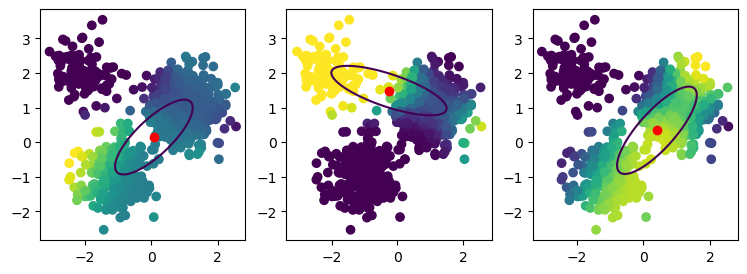

-2752.1050996591784
Maximum number of iterations exhausted.
Stopping after 1 iterations.


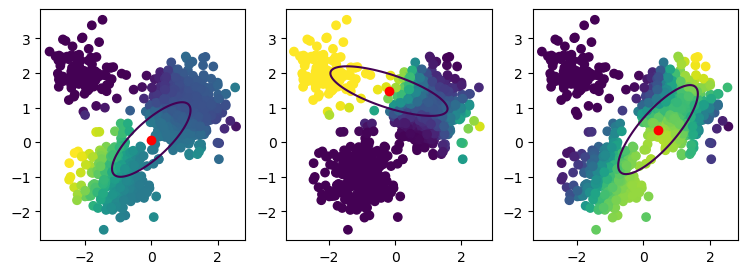

-2749.709104452022
Maximum number of iterations exhausted.
Stopping after 1 iterations.


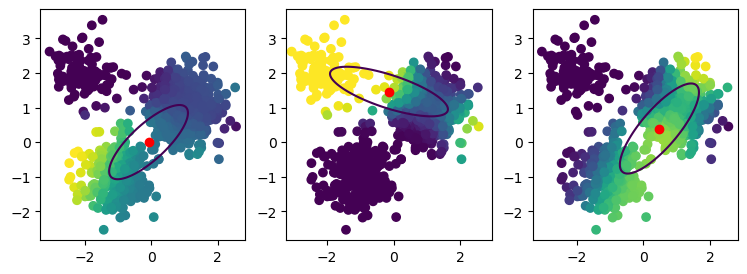

-2747.5009273552823
Maximum number of iterations exhausted.
Stopping after 1 iterations.


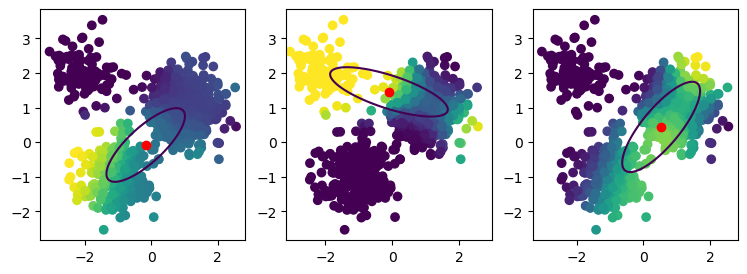

-2745.0217887983563
Maximum number of iterations exhausted.
Stopping after 1 iterations.


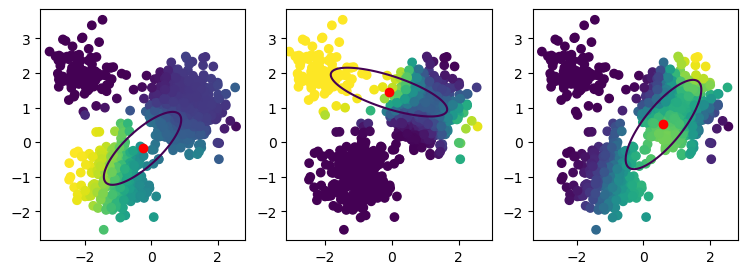

-2740.939782503733
Maximum number of iterations exhausted.
Stopping after 1 iterations.


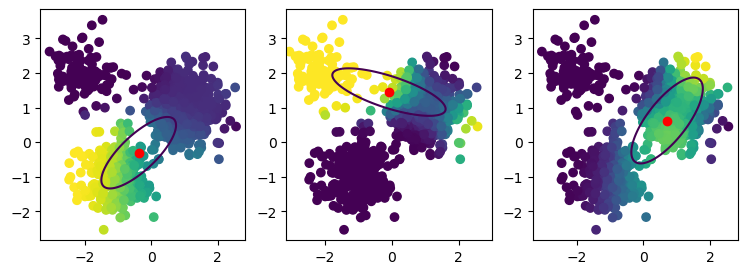

-2729.262692365386
Maximum number of iterations exhausted.
Stopping after 1 iterations.


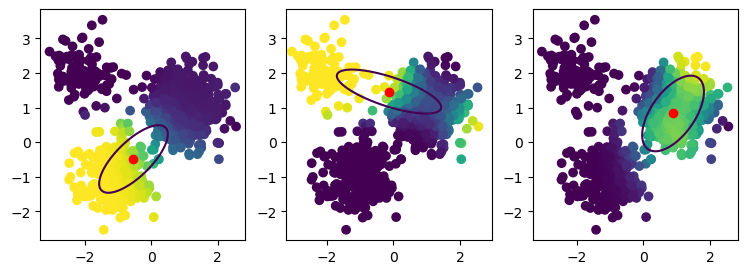

-2667.2645226071154
Maximum number of iterations exhausted.
Stopping after 1 iterations.


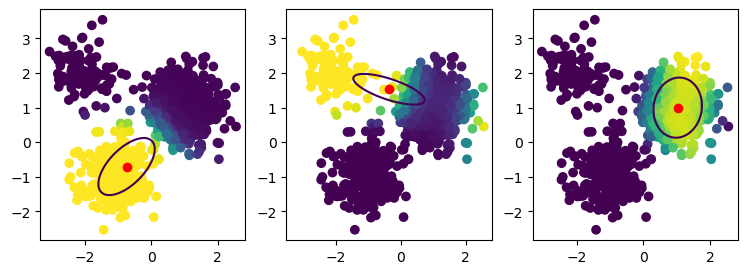

-2525.458969978718
Maximum number of iterations exhausted.
Stopping after 1 iterations.


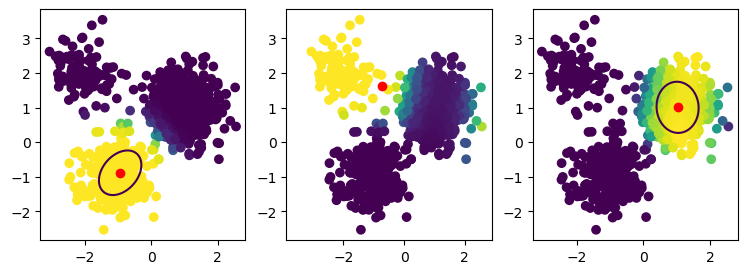

-2461.8539767817524
Maximum number of iterations exhausted.
Stopping after 1 iterations.


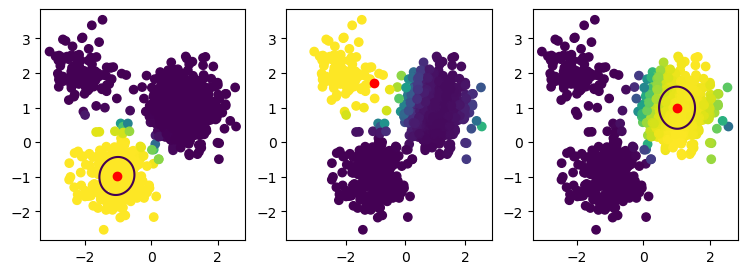

-2429.542119210274
Maximum number of iterations exhausted.
Stopping after 1 iterations.


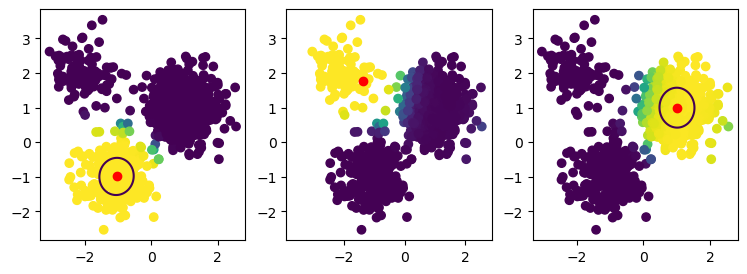

-2419.9310727736442
Maximum number of iterations exhausted.
Stopping after 1 iterations.


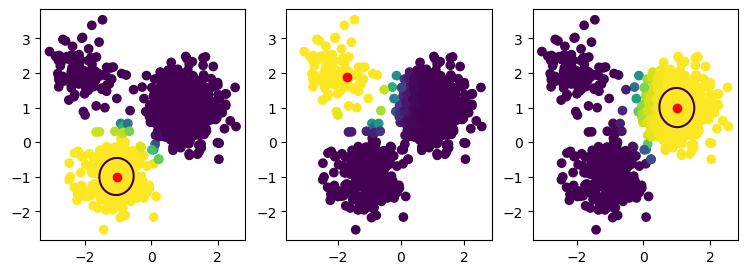

-2402.7967081682827
Maximum number of iterations exhausted.
Stopping after 1 iterations.


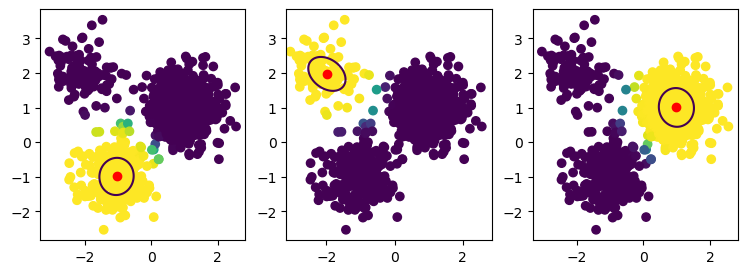

-2379.3127545500056
Maximum number of iterations exhausted.
Stopping after 1 iterations.


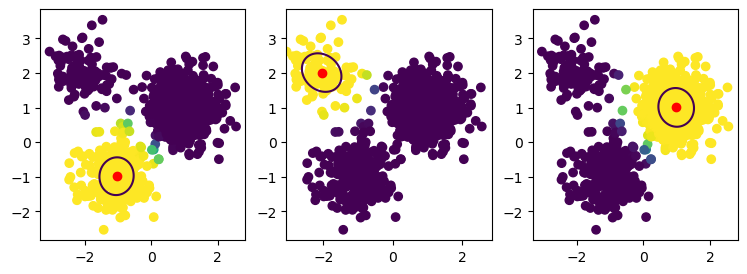

-2375.8469988657084
Minimum likelihood change not reached.
Stopping after 1 iterations.


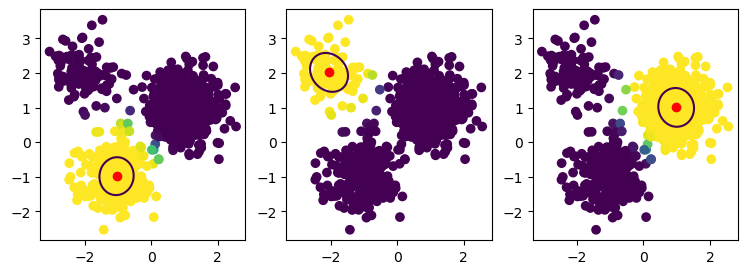

-2375.7909755354613
Minimum likelihood change not reached.
Stopping after 1 iterations.


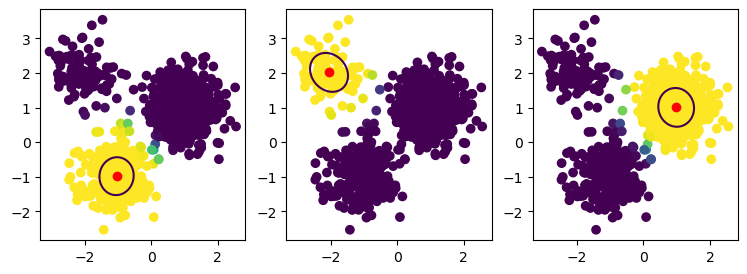

-2375.790743592631
Minimum likelihood change not reached.
Stopping after 1 iterations.


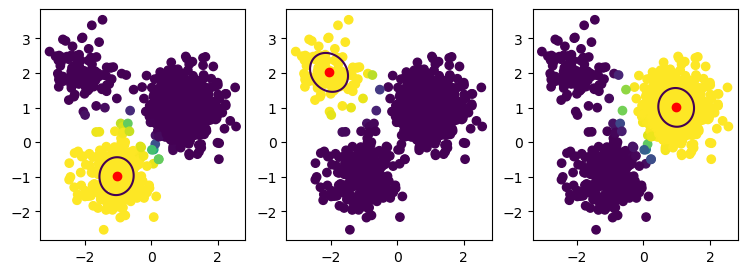

-2375.7907427906466
Minimum likelihood change not reached.
Stopping after 1 iterations.


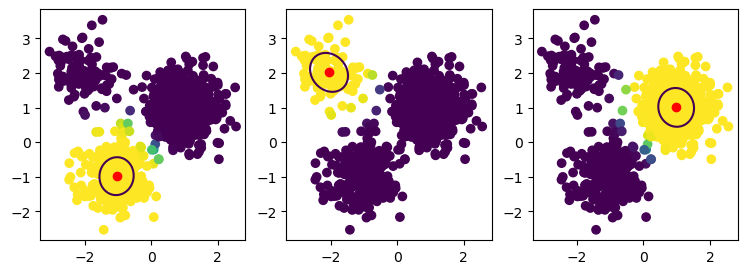

-2375.79074278789
Minimum likelihood change not reached.
Stopping after 1 iterations.


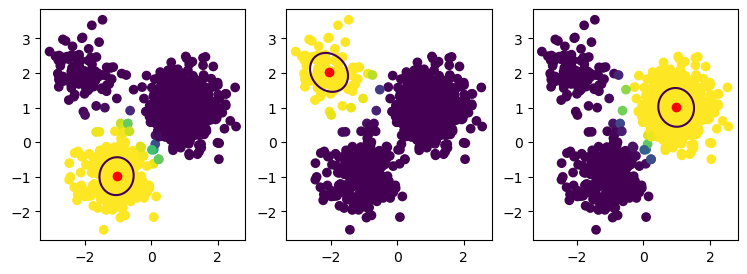

-2375.7907427878804
Minimum likelihood change not reached.
Stopping after 1 iterations.


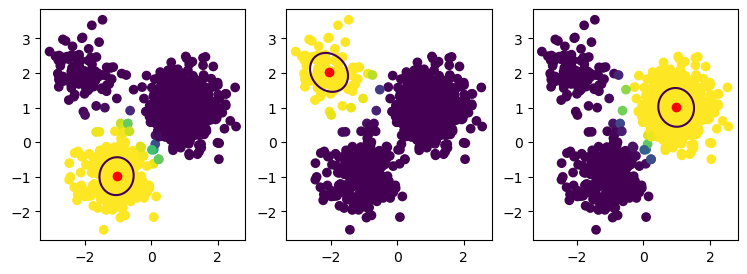

-2375.7907427878804
Minimum likelihood change not reached.
Stopping after 1 iterations.


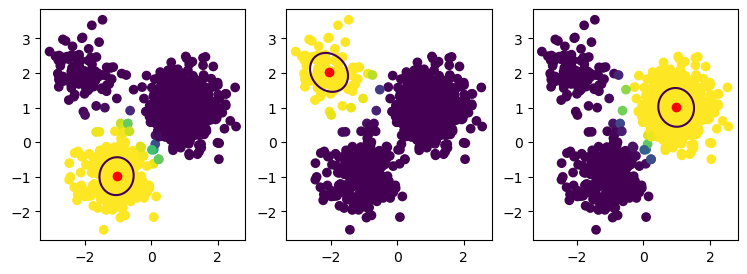

-2375.7907427878804
Minimum likelihood change not reached.
Stopping after 1 iterations.


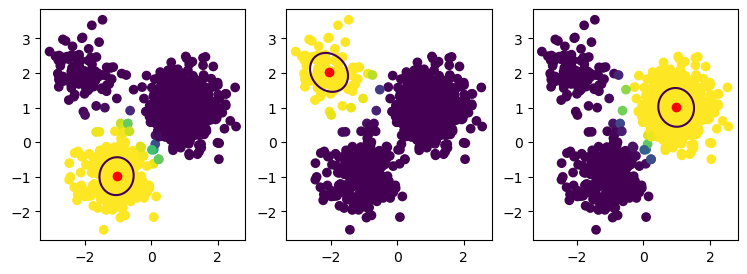

-2375.7907427878804
Minimum likelihood change not reached.
Stopping after 1 iterations.


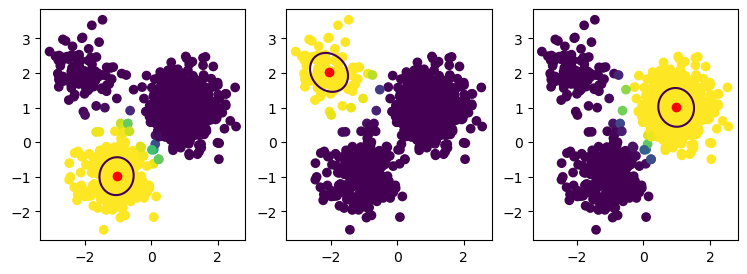

-2375.7907427878804
Likelihood should always increase: -2375.7907427878804 < -2375.79074278788
Minimum likelihood change not reached.
Stopping after 1 iterations.


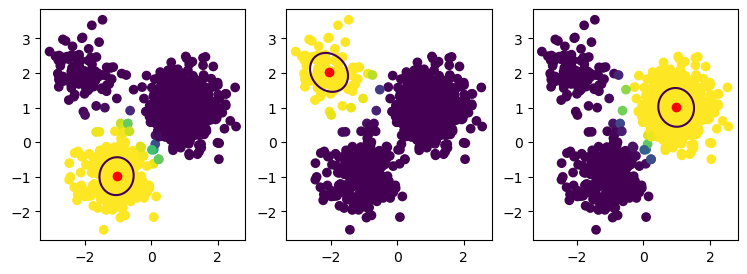

-2375.7907427878804
Likelihood should always increase: -2375.7907427878804 < -2375.79074278788
Minimum likelihood change not reached.
Stopping after 1 iterations.


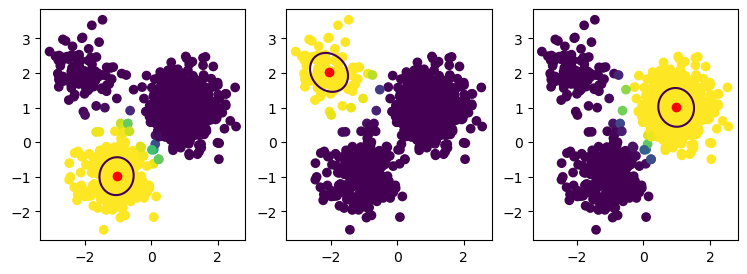

-2375.7907427878804
Minimum likelihood change not reached.
Stopping after 1 iterations.


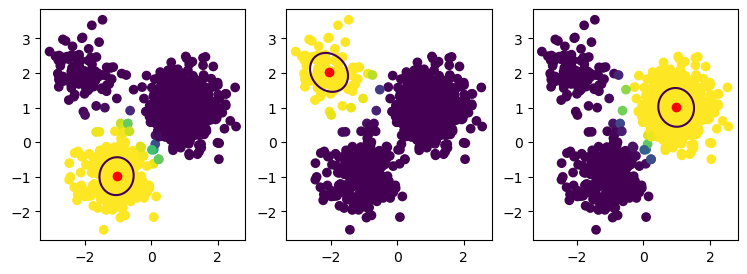

-2375.79074278788
Minimum likelihood change not reached.
Stopping after 1 iterations.


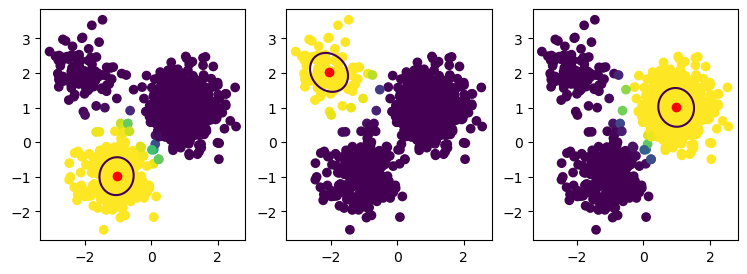

-2375.7907427878804
Minimum likelihood change not reached.
Stopping after 1 iterations.


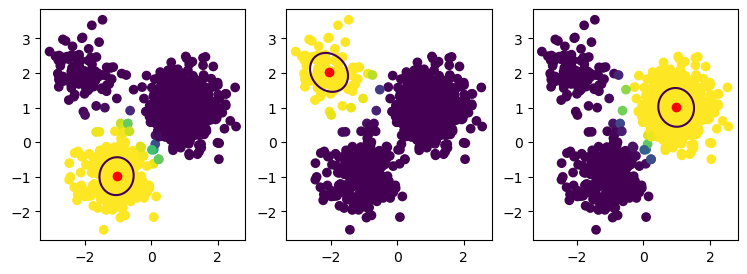

-2375.7907427878804
Minimum likelihood change not reached.
Stopping after 1 iterations.


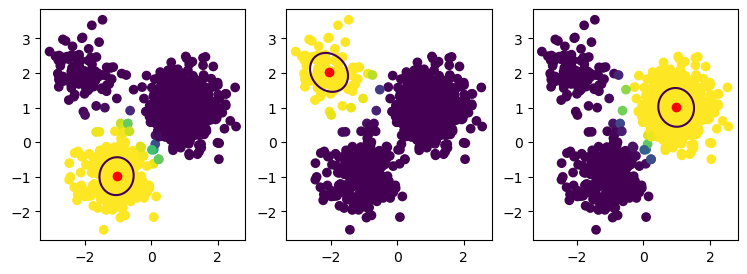

-2375.7907427878804
Minimum likelihood change not reached.
Stopping after 1 iterations.


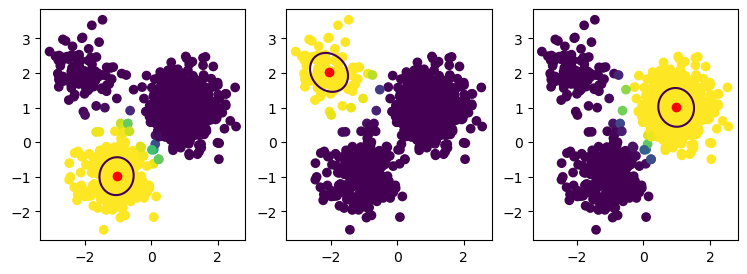

-2375.7907427878804
Minimum likelihood change not reached.
Stopping after 1 iterations.


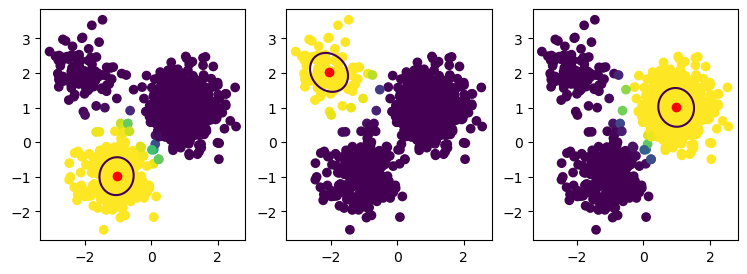

-2375.7907427878804
Minimum likelihood change not reached.
Stopping after 1 iterations.


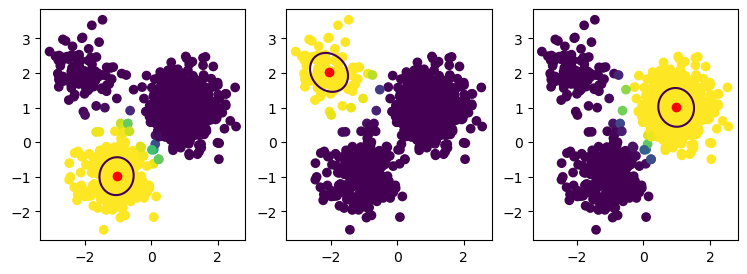

-2375.7907427878804
Minimum likelihood change not reached.
Stopping after 1 iterations.


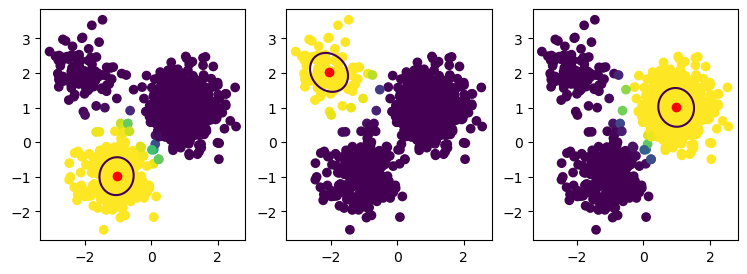

-2375.7907427878804
Minimum likelihood change not reached.
Stopping after 1 iterations.


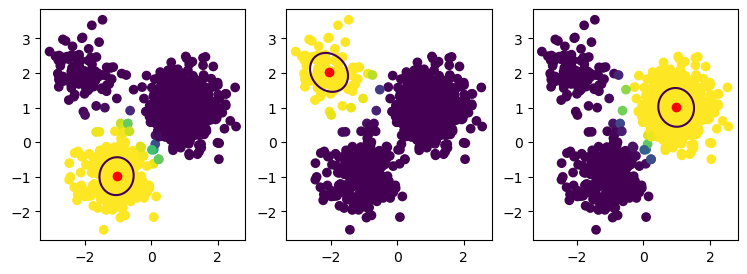

-2375.7907427878804
Minimum likelihood change not reached.
Stopping after 1 iterations.


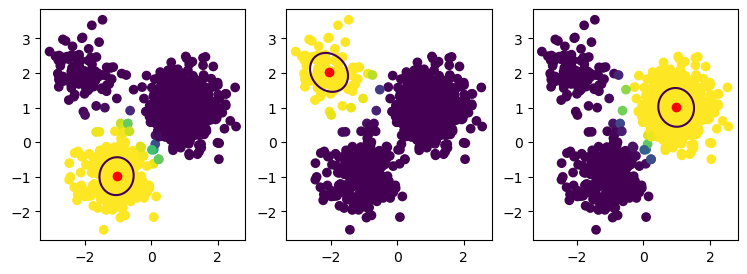

-2375.7907427878804


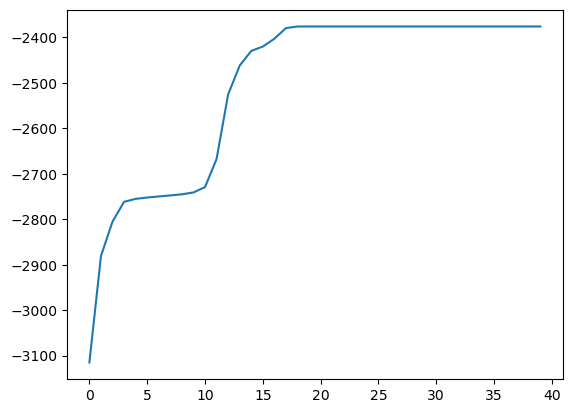

In [6]:
K = 3

affiliations = np.random.uniform(size=(K, N))
affiliations /= affiliations.sum(axis=0)
log_likelihood_history = []
for _ in range(40):
    model, affiliations, log_likelihood = GaussianMixtureModel.fit(x, num_classes=2, initialization=affiliations, iterations=1, verbose=True)
    f = plt.figure(figsize=(3 * K, 3))
    axes = f.subplots(1, K, squeeze=False).flatten()
    for k in range(K):
        axes[k].scatter(x[:, 0], x[:, 1], c=affiliations[k, :])
        plot_multivariate_normal(model.means[k], model.covariances[k], ax=axes[k])
    plt.show()
    print(log_likelihood)
    log_likelihood_history.append(log_likelihood)
plt.plot(log_likelihood_history)
plt.show()

# Production test on aritificial data

Minimum likelihood change not reached.
Stopping after 30 iterations.


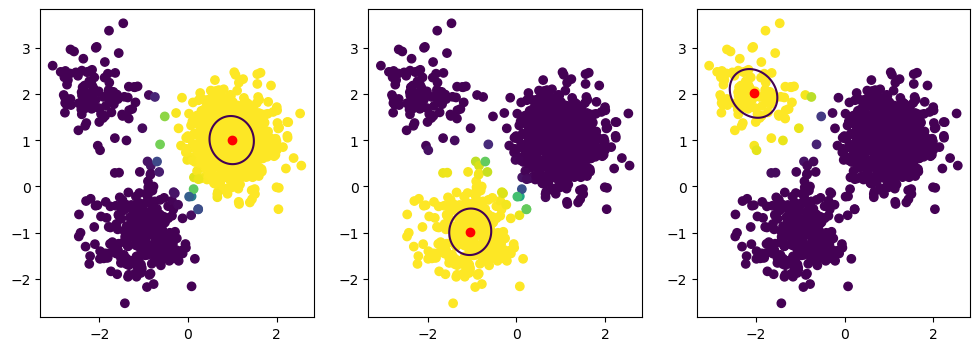

-2375.790896526399


In [7]:
model, affiliations, log_likelihood = GaussianMixtureModel.fit(x, num_classes=K, iterations=100, verbose=True)

f = plt.figure(figsize=(4 * K, 4))
axes = f.subplots(1, K, squeeze=False).flatten()
for k in range(K):
    axes[k].scatter(x[:, 0], x[:, 1], c=affiliations[k, :])
    plot_multivariate_normal(model.means[k], model.covariances[k], ax=axes[k])
    
plt.show()
print(log_likelihood)

In [8]:
model.means

array([[ 0.98408291,  1.00606495],
       [-1.03882284, -0.98311001],
       [-2.05220987,  2.01812046]])

In [9]:
model.weights

array([0.62902926, 0.26776532, 0.10320542])

In [10]:
model.covariances

array([[[ 0.2503804 , -0.01052362],
        [-0.01052362,  0.27234214]],

       [[ 0.26477884,  0.00886649],
        [ 0.00886649,  0.29959872]],

       [[ 0.24915583, -0.04368711],
        [-0.04368711,  0.24179866]]])

In [11]:
np.linalg.det(model.covariances)

array([0.06807839, 0.07924879, 0.05833698])

# Test on real data as an image segmentation task

Now we want to apply the mixture model to an image.
The color is the feature vector.
Once it is trained we can quantize the image.

In [12]:
# Read any image. Try also some other images
image = plt.imread('liliumbulbiferum.jpg', format='jpeg')

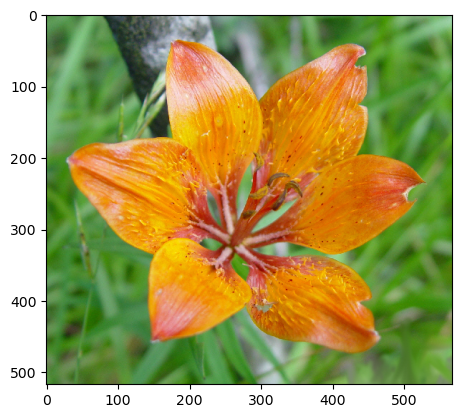

In [14]:
plt.imshow(image)
plt.show()

Minimum likelihood change not reached.
Stopping after 39 iterations.


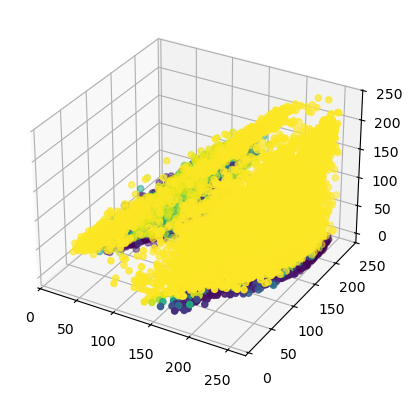

-4152068.706328638


In [15]:
K = 3  # REPLACE K = ???
x_image = image.reshape((-1, 3)).astype(np.float32)
pixels = x_image.shape[0]
model, affiliations, log_likelihood = GaussianMixtureModel.fit(x_image, num_classes=K, iterations=100, verbose=True)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# We here plot every tenth value since it takes quite long with so many data points
slicer = slice(0, None, 10)
x_image_tmp = x_image[::10, :]
ax.scatter(x_image_tmp[:, 0], x_image_tmp[:, 1], x_image_tmp[:, 2], c=affiliations[0, slicer])
plt.show()
print(log_likelihood)

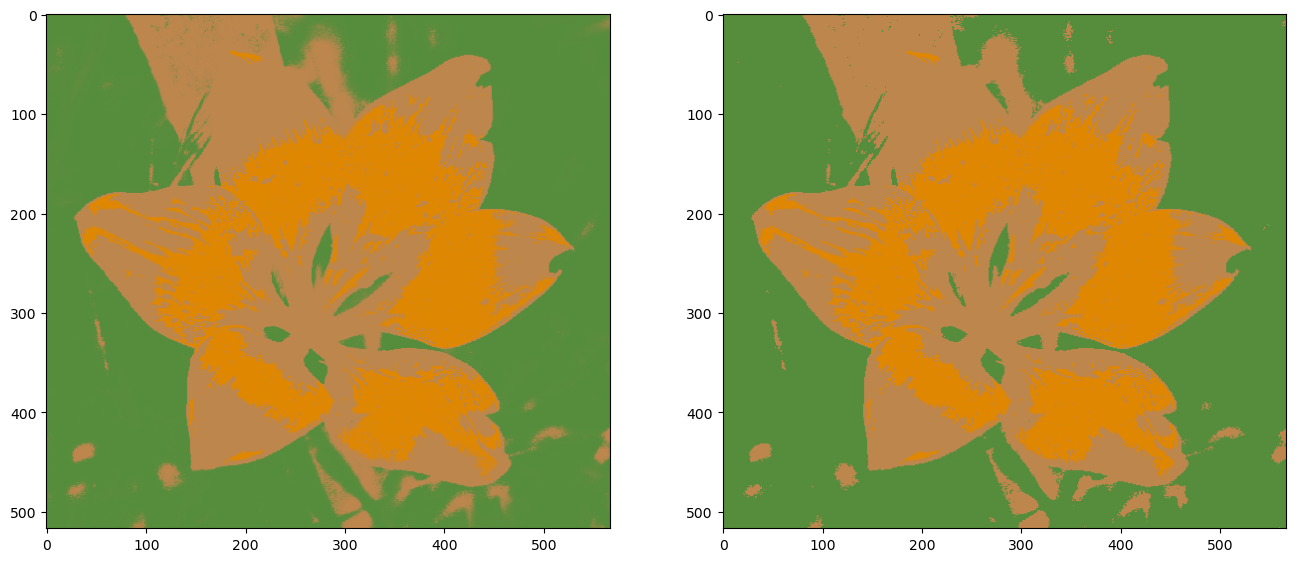

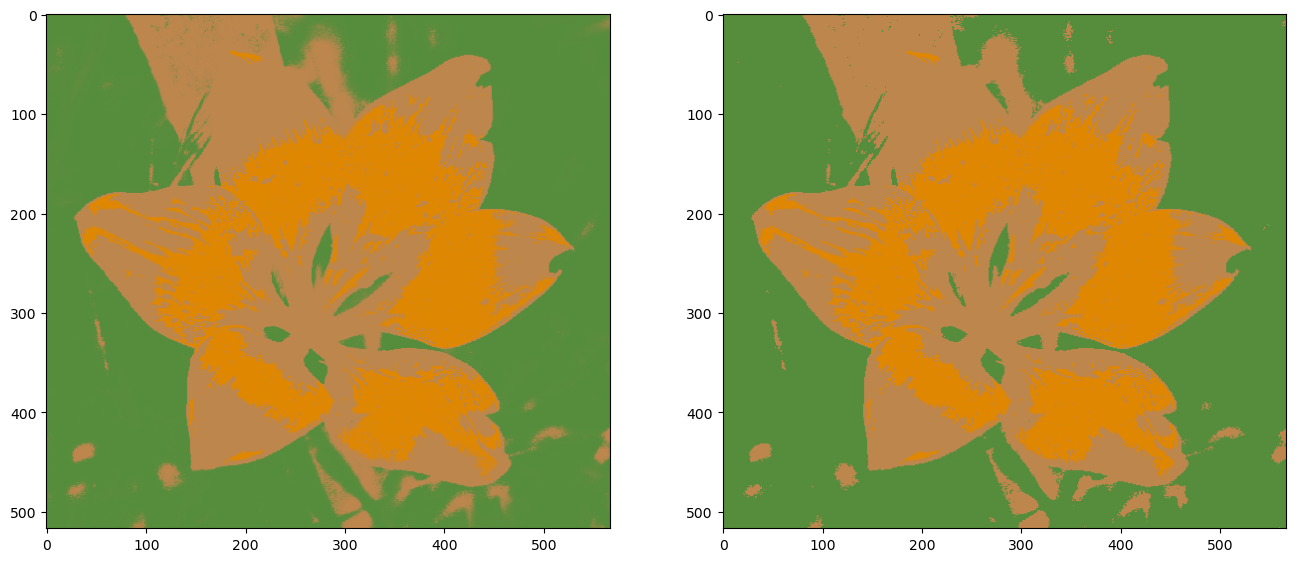

In [17]:
plots = 2
f, axes = plt.subplots(1, plots, figsize=(8 * plots, 8))

new_image = np.zeros([pixels, 3])
for k in range(K):
    color = model.means[k] / 255
    new_image += affiliations[k, :, np.newaxis] * color
    
axes[0].imshow(new_image.reshape(image.shape))

new_image = np.zeros([pixels, 3])
for k in range(K):
    color = model.means[k] / 255
    new_image[np.argmax(affiliations, axis=0) == k, :] = color
    
axes[1].imshow(new_image.reshape(image.shape))
plt.show()

In [18]:
f, axes = plt.subplots(1, K, figsize=(4 * K, 4))
for k, ax in enumerate(axes):
    ax.imshow(affiliations[k].reshape(image[:, :, 0].shape))

# Extra exercise

## Mixture Model for supervised problem

Again we look at the MNIST dataset.
But this time we quantize the image to binary values. So each pixel is either one or zero (e.g. depending if the continuous value is bigger or smaller than 0.5).
Each image, interpreted as a vector, then contains 784 binary values.

Last exercise we saw the multidimensional Bernoulli distribution.
For each label (i.e. the numbers 0 to 9) in the MNIST dataset we can learn the parameters of the Bernoulli distribution on the train set and do a Bayes decision on the test set.

This will work, but the Bernoulli distribution is not optimal to decribe the data.

To improve the model of the data, the multidimensional Bernoulli distribution can be replace with a mixture of multidimensional Bernoulli distribution, where each component is interpreted as a variant of the number.

Task:
 - Implement the multidimensional Bernoulli Mixture Model
 - Download the mnist data
 - Binarize the data 
 - Fit one Mixture Model for each number, try different K's
 - Visualize the parameters of the multidimensional Bernoulli distributions, i.e. plot the means of the mixture model
 - Do a prediction on the test data
 - What is the best accouracy that you can achieve?
 - Visualize a confusion matrix

In [19]:
class BernoulliMixtureModel(GaussianMixtureModel):
    def __init__(self):
        self.means = None  # Shape (K, D)
        self.weights = None  # Shape (K,)
    
    def _m_step(self, x, affiliations):
        N, D = x.shape
        denominator = np.einsum('kn->k', affiliations)  # REPLACE
        self.weights = denominator / N  # REPLACE
        
        self.means = np.einsum('kn,nd->kd', affiliations, x)  # REPLACE
        self.means /= denominator[:, None]  # REPLACE
    
    def _e_step(self, x):
        N, D = x.shape
        K = self.weights.shape[0]
        
        def log(array):  # REPLACE
            return np.log(np.maximum(array, np.finfo(array.dtype).tiny))  # REPLACE
        
        log_conditional_pdf = np.zeros((K, N))  # REPLACE
        log_conditional_pdf += log(self.means) @ x.T + log(1 - self.means) @ (1 - x).T  # REPLACE
    
        log_joint_pdf = log_conditional_pdf + np.log(self.weights)[:, None]  # REPLACE
        affiliations = np.exp(log_joint_pdf)  # REPLACE
        affiliations /= np.maximum(np.einsum('kn->n', affiliations)[None, :], np.finfo(affiliations.dtype).tiny)  # REPLACE
        
        log_likelihood = scipy.special.logsumexp(log_joint_pdf, axis=-2)  # REPLACE
        
        return affiliations, log_likelihood

In [20]:
def get_mnist():
    # The code to download the mnist data original came from
    # https://cntk.ai/pythondocs/CNTK_103A_MNIST_DataLoader.html
    
    import gzip
    import numpy as np
    import os
    import struct

    try: 
        from urllib.request import urlretrieve 
    except ImportError: 
        from urllib import urlretrieve

    def load_data(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x3080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))[0]
                if n != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} entries.".format(num_samples)
                    )
                crow = struct.unpack(">I", gz.read(4))[0]
                ccol = struct.unpack(">I", gz.read(4))[0]
                if crow != 28 or ccol != 28:
                    raise Exception(
                        "Invalid file: expected 28 rows/cols per image."
                    )
                # Read data.
                res = np.frombuffer(
                    gz.read(num_samples * crow * ccol), dtype=np.uint8
                )
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples, crow, ccol)) / 256


    def load_labels(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x1080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))
                if n[0] != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} rows.".format(num_samples)
                    )
                # Read labels.
                res = np.frombuffer(gz.read(num_samples), dtype=np.uint8)
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples))


    def try_download(data_source, label_source, num_samples):
        data = load_data(data_source, num_samples)
        labels = load_labels(label_source, num_samples)
        return data, labels
    
    # Not sure why, but yann lecun's website does no longer support 
    # simple downloader. (e.g. urlretrieve and wget fail, while curl work)
    # Since not everyone has linux, use a mirror from uni server.
    #     server = 'http://yann.lecun.com/exdb/mnist'
    server = 'https://raw.githubusercontent.com/fgnt/mnist/master'
    
    # URLs for the train image and label data
    url_train_image = f'{server}/train-images-idx3-ubyte.gz'
    url_train_labels = f'{server}/train-labels-idx1-ubyte.gz'
    num_train_samples = 60000

    print("Downloading train data")
    train_features, train_labels = try_download(url_train_image, url_train_labels, num_train_samples)

    # URLs for the test image and label data
    url_test_image = f'{server}/t10k-images-idx3-ubyte.gz'
    url_test_labels = f'{server}/t10k-labels-idx1-ubyte.gz'
    num_test_samples = 10000

    print("Downloading test data")
    test_features, test_labels = try_download(url_test_image, url_test_labels, num_test_samples)
    
    return train_features, train_labels, test_features, test_labels

In [21]:
train_features, train_labels, test_features, test_labels = get_mnist()

Done.
Done.
Done.
Done.


In [22]:
train_features.shape

(60000, 28, 28)

In [23]:
models = {}

train_features_binary = np.array(train_features > 0.5, dtype=np.float64)

for i in range(10):
    train_subset_X = train_features_binary[train_labels == i]
    model_X, affiliations_X, log_likelihood_X = BernoulliMixtureModel.fit(train_subset_X.reshape(-1, 28*28), num_classes=10, iterations=20, verbose=True)  # REPLACE
    models[i] = model_X  # REPLACE models[i] = ???


Maximum number of iterations exhausted.
Stopping after 20 iterations.
Maximum number of iterations exhausted.
Stopping after 20 iterations.
Maximum number of iterations exhausted.
Stopping after 20 iterations.
Maximum number of iterations exhausted.
Stopping after 20 iterations.
Maximum number of iterations exhausted.
Stopping after 20 iterations.
Maximum number of iterations exhausted.
Stopping after 20 iterations.
Maximum number of iterations exhausted.
Stopping after 20 iterations.
Maximum number of iterations exhausted.
Stopping after 20 iterations.
Maximum number of iterations exhausted.
Stopping after 20 iterations.
Maximum number of iterations exhausted.
Stopping after 20 iterations.


In [24]:
for i, model_X in models.items():
    for image, ax in zip(model_X.means.reshape(-1, 28, 28), plt.subplots(1, len(model_X.means), squeeze=False)[1].ravel()):
        ax.imshow(image)

In [25]:
predict = np.argmax(np.array([model_X._e_step(test_features.reshape(-1, 28*28) > 0.5)[1] for i, model_X in sorted(models.items())]), axis=0)  # REPLACE predict = ???
acc = np.mean(predict == test_labels)
acc

0.9251

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, predict)

array([[ 944,    0,    7,    1,    1,    6,    6,    0,   11,    4],
       [   0, 1110,    7,    1,    0,    0,    4,    0,   11,    2],
       [   9,    6,  948,   18,    3,    2,    4,    6,   32,    4],
       [   1,    2,   13,  915,    1,   19,    0,   11,   35,   13],
       [   0,    2,    7,    0,  880,    0,   10,   11,   12,   60],
       [   8,    3,    2,   30,    4,  797,    7,    0,   35,    6],
       [   7,    5,    6,    0,    5,    8,  918,    0,    9,    0],
       [   0,    4,   14,    3,    6,    1,    1,  936,    7,   56],
       [   6,    2,    6,   25,    6,   23,    1,    7,  888,   10],
       [   3,    8,    4,   11,   39,    0,    0,   18,   11,  915]],
      dtype=int64)

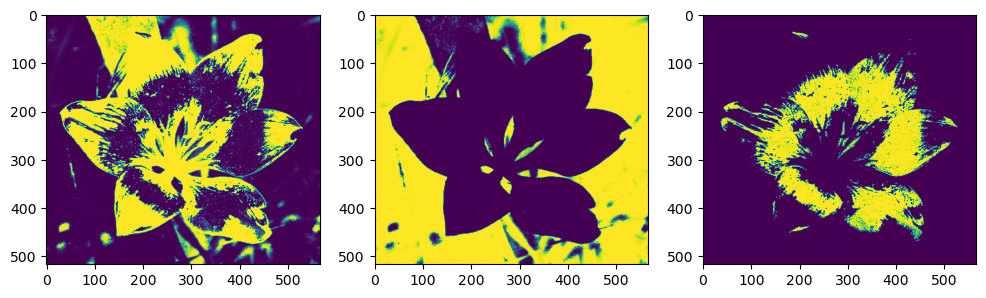

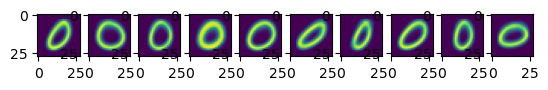

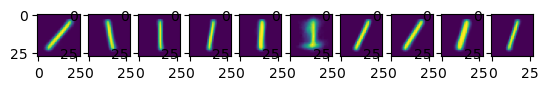

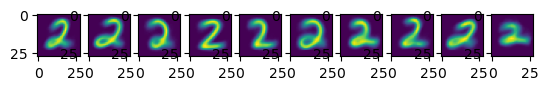

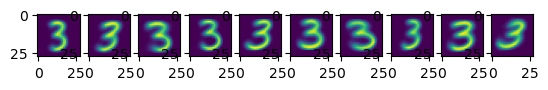

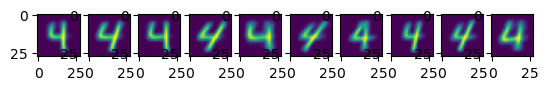

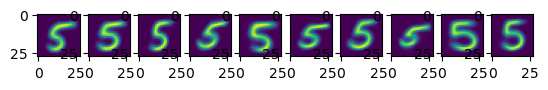

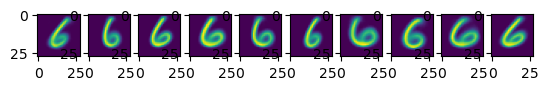

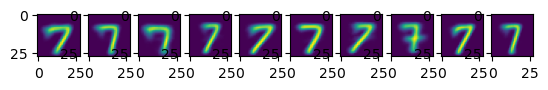

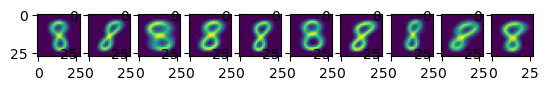

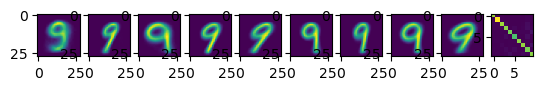

In [27]:
plt.imshow(confusion_matrix(test_labels, predict))
plt.show()

In [28]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    from sklearn import svm, datasets
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(test_labels, predict, classes=np.arange(10),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(test_labels, predict, classes=np.arange(10), normalize=True,
                      title='Normalized confusion matrix')

Confusion matrix, without normalization
[[ 944    0    7    1    1    6    6    0   11    4]
 [   0 1110    7    1    0    0    4    0   11    2]
 [   9    6  948   18    3    2    4    6   32    4]
 [   1    2   13  915    1   19    0   11   35   13]
 [   0    2    7    0  880    0   10   11   12   60]
 [   8    3    2   30    4  797    7    0   35    6]
 [   7    5    6    0    5    8  918    0    9    0]
 [   0    4   14    3    6    1    1  936    7   56]
 [   6    2    6   25    6   23    1    7  888   10]
 [   3    8    4   11   39    0    0   18   11  915]]
Normalized confusion matrix
[[9.63e-01 0.00e+00 7.14e-03 1.02e-03 1.02e-03 6.12e-03 6.12e-03 0.00e+00
  1.12e-02 4.08e-03]
 [0.00e+00 9.78e-01 6.17e-03 8.81e-04 0.00e+00 0.00e+00 3.52e-03 0.00e+00
  9.69e-03 1.76e-03]
 [8.72e-03 5.81e-03 9.19e-01 1.74e-02 2.91e-03 1.94e-03 3.88e-03 5.81e-03
  3.10e-02 3.88e-03]
 [9.90e-04 1.98e-03 1.29e-02 9.06e-01 9.90e-04 1.88e-02 0.00e+00 1.09e-02
  3.47e-02 1.29e-02]
 [0.00e+00 2.04e-03 7

<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>